In [1]:
import random
import torch
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# 🔍 **Load Dataset**
print("\n🔍 Loading sequences with CDR-masked variants...")
file_path = "processed_unlabelled_sequences.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Ensure data has the correct format
if "sequence" not in df.columns or "masked_sequence" not in df.columns:
    raise ValueError("❌ CSV must contain 'sequence' and 'masked_sequence' columns!")

print(f"✅ Loaded {len(df)} sequences.")

# **📊 Split into Train and Validation**
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"✅ Stratified Dataset Split: {len(train_df)} training, {len(valid_df)} validation samples.")

# Reset any existing indices to avoid generating extra columns like "__index_level_0__"
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

# Convert to Hugging Face Dataset format
dataset_train = Dataset.from_pandas(train_df)
dataset_valid = Dataset.from_pandas(valid_df)

# 🚀 **Load Tokeniser**
checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def simple_tokenize_function(examples):
    """
    Tokenise sequences without applying any static masking.
    We keep 'sequence' and 'masked_sequence' for reference in the collator.
    """
    tokenised = tokenizer(
        [s.strip() for s in examples["sequence"]],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    
    # Keep these strings so the collator can identify CDR positions
    tokenised["sequence"] = [s.split() for s in examples["sequence"]]
    tokenised["masked_sequence"] = [s.split() for s in examples["masked_sequence"]]
    return tokenised

print("\n🔄 Tokenising sequences (without static masking)...")
tokenized_train = dataset_train.map(simple_tokenize_function, batched=True)
tokenized_valid = dataset_valid.map(simple_tokenize_function, batched=True)
print("✅ Tokenisation complete.")

class DataCollatorCDRMasking:
    """
    Data collator that applies dynamic masking ONLY to CDR positions (identified
    by comparing 'sequence' vs 'masked_sequence').
    """
    def __init__(self, tokenizer, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.mlm_probability = mlm_probability

    def __call__(self, features):
        # 1) Dynamic masking logic first
        for i, f in enumerate(features):
            # Identify CDR positions
            cdr_positions = compute_cdr_indices(f["sequence"], f["masked_sequence"])
            # Randomly choose subset
            num_to_mask = max(1, int(len(cdr_positions) * self.mlm_probability))
            positions_to_mask = random.sample(
                cdr_positions,
                min(num_to_mask, len(cdr_positions))
            )

            # Prepare input_ids and labels
            input_ids_list = f["input_ids"][:]
            labels_list = input_ids_list[:]

            # BERT-like random replacement
            for i, pos in enumerate(positions_to_mask):
                rand_draw = random.random()
                if rand_draw < 0.8:
                    input_ids_list[pos] = self.tokenizer.mask_token_id
                elif rand_draw < 0.9:
                    input_ids_list[pos] = random.randint(0, self.tokenizer.vocab_size - 1)
                else:
                    pass

            for pos in range(len(labels_list)):
                if pos not in positions_to_mask:
                    labels_list[pos] = -100

            f["input_ids"] = input_ids_list
            f["labels"] = labels_list
            # Remove strings before padding
            f.pop("sequence")
            f.pop("masked_sequence")

        # 2) Call tokenizer.pad(...) for proper batching
        batch = self.tokenizer.pad(features, padding=True, return_tensors="pt")
        return batch

def compute_cdr_indices(seq_unmasked: str, seq_masked: str) -> list:
    """
    Identify the indices where 'masked_sequence' has '<mask>' => CDR positions.
    Assumes seq_unmasked and seq_masked are aligned 1-to-1 at each index.
    """
    cdr_positions = []
    for idx, (u_char, m_char) in enumerate(zip(seq_unmasked, seq_masked)):
        if m_char == "<mask>":
            cdr_positions.append(idx)
    return cdr_positions

print(f"\n🚀 Loading ESM model for MLM from: {checkpoint}")
model_mlm = AutoModelForMaskedLM.from_pretrained(checkpoint)
print("✅ Model loaded successfully.")

# ---------------------------
#  ADDING LR SCHEDULER, WARMUP, AND EARLY STOPPING
# ---------------------------

training_args = TrainingArguments(
    output_dir="./esm_mlm_cdr_pretraining",
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",        # Save model every epoch
    fp16=torch.cuda.is_available(),
    learning_rate=3e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,  # Let's increase to 10, so we can observe early stopping
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=10,
    report_to="none",
    optim="adamw_torch",
    remove_unused_columns=False,
    
    # >>> WARMUP & LR SCHEDULER:
    # We'll do a linear schedule with 10% warmup.
    lr_scheduler_type="linear",
    warmup_ratio=0.1,  # or warmup_steps=...
    
    # >>> EARLY STOPPING REQUIRES EVAL
    # So we can set load_best_model_at_end and track eval_loss
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # We want to track validation loss
)

print(f"✅ Training Arguments Configured: {training_args}")

cdr_data_collator = DataCollatorCDRMasking(
    tokenizer=tokenizer,
    mlm_probability=0.15
)

# >>> EARLY STOPPING CALLBACK
# This will stop training if eval_loss fails to improve for 'patience' epochs.
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,    # how many consecutive evals without improvement
    early_stopping_threshold=0.0  # min improvement to be considered
)

trainer = Trainer(
    model=model_mlm,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=cdr_data_collator,
    callbacks=[early_stopping_callback],  # attach the early stopping callback
)

print("✅ Trainer initialised successfully.")

# 🚀 **Start Dynamic Masking Pre-training**
print("\n🚀 Starting MLM Pre-training on masked CDR sequences (dynamic approach)...")
trainer.train()
print("\n✅ Pre-training complete!")

# 💾 **Save Pre-Trained Model**
print("\n💾 Saving pre-trained model...")
model_mlm.save_pretrained("./esm_mlm_cdr_pretrained_150M")
tokenizer.save_pretrained("./esm_mlm_cdr_pretrained_150M")
print("✅ Pre-trained model saved successfully.")


/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🔍 Loading sequences with CDR-masked variants...
✅ Loaded 31914 sequences.
✅ Stratified Dataset Split: 25531 training, 6383 validation samples.

🔄 Tokenising sequences (without static masking)...


Map: 100%|██████████| 6383/6383 [00:07<00:00, 827.73 examples/s]


✅ Tokenisation complete.

🚀 Loading ESM model for MLM from: facebook/esm2_t30_150M_UR50D
✅ Model loaded successfully.
✅ Training Arguments Configured: TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eva

/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_7547/3237987501.py:173: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Trainer initialised successfully.

🚀 Starting MLM Pre-training on masked CDR sequences (dynamic approach)...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [26]:
# Grab 2-3 examples from tokenized_train
sample_features = [tokenized_train[i] for i in range(3)]
batch = cdr_data_collator(sample_features)

print("input_ids[0]:", batch["input_ids"][0])
print("labels[0]:   ", batch["labels"][0])
print("mask_token_id:", tokenizer.mask_token_id)

input_ids[0]: tensor([ 0, 16,  7, 16,  4,  7, 16,  8,  6,  5,  9,  7, 15, 15, 14,  6,  5,  8,
         7, 15,  7,  8, 23, 15,  7,  8, 32, 19, 32, 18,  8, 17, 21,  5, 12, 21,
        22,  7, 10, 16,  5, 14,  6, 15,  6,  4,  9, 22, 20,  6, 32, 12, 17, 14,
        17, 12,  6, 13, 11, 12, 19,  5, 16, 15, 18, 16,  6, 10,  7, 11, 20, 11,
         9, 13, 11,  8, 11, 13, 11,  5, 19, 20,  9,  4,  8,  8,  4, 15,  8,  9,
        13, 11,  5,  7, 19, 19, 23,  5, 15, 13,  6, 22,  8,  8, 18, 22, 17,  6,
        12,  5,  7,  5,  6,  4, 13, 19, 22,  6, 16,  6, 11,  4,  7, 11,  7,  8,
         8,  3, 13, 12, 16, 20, 11, 16,  8, 14,  8,  8,  7,  8,  5,  8,  7,  6,
        13, 10,  7, 11, 12, 11, 23, 10,  5, 32, 16, 13, 12,  6, 21, 19,  4,  5,
        22, 19, 16, 16, 15, 14,  6, 15,  5, 14, 15,  4,  4, 12, 19,  5,  8,  8,
        17,  4,  5,  8,  6,  7, 14,  8, 10, 18,  8,  6,  8,  6,  8,  6, 11, 13,
        18, 11,  4, 11, 12,  8,  8,  4, 16, 14,  9, 13, 18,  5, 17, 19, 19, 23,
        21, 16, 19,  5, 11

In [27]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

# Load the saved model and tokenizer
model_checkpoint = "./esm_mlm_cdr_pretrained"
print(f"🚀 Loading trained MLM model from: {model_checkpoint}")

model_mlm = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print("✅ Model and tokenizer loaded successfully.")

# Run evaluation on the validation dataset
print("\n📊 Evaluating MLM performance on validation dataset...")
eval_results = trainer.evaluate()

# Print evaluation results
print("\n🔍 MLM Validation Evaluation Metrics:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

🚀 Loading trained MLM model from: ./esm_mlm_cdr_pretrained
✅ Model and tokenizer loaded successfully.

📊 Evaluating MLM performance on validation dataset...



🔍 MLM Validation Evaluation Metrics:
eval_loss: 0.0929
eval_runtime: 32.4291
eval_samples_per_second: 196.8290
eval_steps_per_second: 12.3040
epoch: 24.0000


In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

# **🚀 Load Pretrained Model & Tokenizer**
checkpoint = "./esm_mlm_cdr_pretrained"  # Adjust if different
print(f"\n🚀 Loading pre-trained model from: {checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForMaskedLM.from_pretrained(checkpoint)
model.eval()  # Set to evaluation mode
print("✅ Model loaded successfully.")

# **🔄 Define Function for Prediction**
def predict_masked_sequence(masked_sequence):
    """Predicts masked tokens in a given sequence using the trained MLM model."""
    
    # Tokenize input sequence
    inputs = tokenizer(masked_sequence, return_tensors="pt")
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits  # Model outputs (logits for each token)
    masked_indices = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]  # Get <mask> positions

    print("\n🔍 **Predicted Residues at Masked Positions:**")
    
    for idx in masked_indices:
        predicted_token_id = torch.argmax(logits[0, idx]).item()  # Get most likely token
        predicted_token = tokenizer.decode([predicted_token_id])  # Convert ID to actual amino acid
        
        print(f"Position {idx}: Predicted → {predicted_token}")

    # Convert full sequence with predictions
    predicted_ids = inputs.input_ids.clone()
    for idx in masked_indices:
        predicted_ids[0, idx] = torch.argmax(logits[0, idx]).item()
    
    predicted_sequence = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
    print("\n✅ **Reconstructed Sequence:**")
    print(predicted_sequence.replace(' ', ''))

    return predicted_sequence


# **📌 Example Masked Input**
masked_sequence = valid_df['masked_sequence'].values[0]
actual_sequence = valid_df['sequence'].values[0]
print("\n🔍 Evaluating masked sequence:")
print(masked_sequence)
print(actual_sequence)
# **🚀 Get Predictions**
predicted_sequence = predict_masked_sequence(masked_sequence)



🚀 Loading pre-trained model from: ./esm_mlm_cdr_pretrained
✅ Model loaded successfully.

🔍 Evaluating masked sequence:
Q V Q L V Q S G A E V K K P G A S V K V S C K V S <mask> <mask> <mask> <mask> <mask> <mask> <mask> I H W V R Q A P G K G L E W M G G <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> I Y A Q K F Q G R V T M T E D T S T D T A Y M E L S S L K S E D T A V Y Y C <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> W G Q G T T V T V S S : D I Q M T Q S P S S V S A S V G D R V T I T C R A S <mask> <mask> <mask> <mask> <mask> <mask> L A W Y Q Q K P G K A P K L L I Y <mask> <mask> <mask> <mask> <mask> <mask> <mask> G V P S R F S G S G S G T D F T L T I S S L Q P E D F A N Y Y C <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> F G G G T K V E I K
Q V Q L V Q S G A E V K K P G A S V K V S C K V S G Y T S P T T I H W V R Q A P G K G L E W M G G I S P Y R G D T I Y A Q K F Q G R V T M T E D T S T D T A Y M E 

In [48]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
)
from datasets import Dataset
from peft import LoraConfig, inject_adapter_in_model
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split

checkpoint = "./esm_mlm_cdr_pretrained"

# **🔍 Load the labeled dataset (binding affinities)**
print("\n🔍 Loading labeled dataset for fine-tuning...")
file_path = "processed_sequences.csv"  # Replace with actual file path

df = pd.read_csv(file_path)


if "sequence" not in df.columns or "binding_affinity" not in df.columns:
    raise ValueError("❌ CSV must contain 'sequence' and 'binding_affinity' columns.")


df["binding_affinity"] = df["binding_affinity"].astype(float)

# Define the number of bins (adjust depending on dataset size)
num_bins = 10  # More bins → finer stratification

# Create bins based on binding affinity distribution
df["affinity_bin"] = pd.qcut(df["binding_affinity"], num_bins, labels=False, duplicates="drop")

# Stratified train-test split
train_df, valid_df = train_test_split(df, test_size=0.1, stratify=df["affinity_bin"], random_state=42)

# Drop the auxiliary bin column
train_df = train_df.drop(columns=["affinity_bin"])
valid_df = valid_df.drop(columns=["affinity_bin"])

print(f"✅ Stratified Dataset Split: {len(train_df)} training, {len(valid_df)} validation samples.")

# 🚀 Load Pre-Trained Model for Sequence Classification
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# 🔄 Tokenization Function
def tokenize_function(examples):
    encoding = tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=256)
    encoding["labels"] = examples["binding_affinity"]  # Ensure labels are attached
    return encoding

# 🔄 Tokenizing Training and Validation Data
print("\n🔄 Tokenizing data...")
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
valid_dataset = Dataset.from_pandas(valid_df).map(tokenize_function, batched=True)
print("✅ Tokenization complete.")

# 🚀 Debug: Check a sample output
print("🔍 Sample training data:", train_dataset[0])

# **🚀 Load Pre-Trained Model for Sequence Classification**
print("\n🚀 Loading pre-trained model for regression...")
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=1  # Ensure it is configured for regression
)

# **🛠️ Inject LoRA Adaptation (Optional)**
peft_config = LoraConfig(r=8, lora_alpha=2, bias="all", target_modules=["query", "key", "value", "dense"])
model = inject_adapter_in_model(peft_config, model)
print("✅ LoRA adapter injected.")

# **🛠️ Define Training Arguments**
training_args = TrainingArguments(
    output_dir="./esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_steps=10,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,  # or warmup_steps=...
)

# **🚀 Initialize Trainer**
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if no improvement for 3 epochs
)

# **🚀 Start Fine-Tuning**
print("\n🚀 Fine-tuning model on binding affinity data...")
trainer.train()
print("\n✅ Fine-tuning complete!")

# **💾 Save the Model**
print("\n💾 Saving fine-tuned model...")
model.save_pretrained("./esm_finetuned")
tokenizer.save_pretrained("./esm_finetuned")
print("✅ Fine-tuned model saved successfully.")

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./esm_mlm_cdr_pretrained and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Loading labeled dataset for fine-tuning...
✅ Stratified Dataset Split: 127 training, 15 validation samples.

🚀 Loading pre-trained model for regression...

🔄 Tokenizing data...


Map: 100%|██████████| 15/15 [00:00<00:00, 743.66 examples/s]
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./esm_mlm_cdr_pretrained and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sagemaker-user/.conda/envs/esm-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4090/38507667.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Tokenization complete.
🔍 Sample training data: {'sequence': 'QVQLVQSGAEVKKPGASVKVSCKVSGYSFTDHSIHWVRQAPGKGLEWMGGINPYTGDTIYAQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCARDGYGDYRGLYGMDVWGQGTTVTVSS:DIQMTQSPSSVSASVGDRVTITCRASQDIGNHLAWYQQKPGKAPKLLIYGESNRATGVPSRFSGSGSGTDFTLTISSLQPEDFANYYCHQYATYPWTFGGGTKVEIK', 'binding_affinity': 0.1938330230291761, '__index_level_0__': 53, 'input_ids': [0, 16, 7, 16, 4, 7, 16, 8, 6, 5, 9, 7, 15, 15, 14, 6, 5, 8, 7, 15, 7, 8, 23, 15, 7, 8, 6, 19, 8, 18, 11, 13, 21, 8, 12, 21, 22, 7, 10, 16, 5, 14, 6, 15, 6, 4, 9, 22, 20, 6, 6, 12, 17, 14, 19, 11, 6, 13, 11, 12, 19, 5, 16, 15, 18, 16, 6, 10, 7, 11, 20, 11, 9, 13, 11, 8, 11, 13, 11, 5, 19, 20, 9, 4, 8, 8, 4, 15, 8, 9, 13, 11, 5, 7, 19, 19, 23, 5, 10, 13, 6, 19, 6, 13, 19, 10, 6, 4, 19, 6, 20, 13, 7, 22, 6, 16, 6, 11, 11, 7, 11, 7, 8, 8, 3, 13, 12, 16, 20, 11, 16, 8, 14, 8, 8, 7, 8, 5, 8, 7, 6, 13, 10, 7, 11, 12, 11, 23, 10, 5, 8, 16, 13, 12, 6, 17, 21, 4, 5, 22, 19, 16, 16, 15, 14, 6, 15, 5, 14, 15, 4, 4, 12, 19, 6, 9,

Epoch,Training Loss,Validation Loss
1,0.139600,0.129265
2,0.086400,0.070814
3,0.075300,0.054278
4,0.069000,0.052485
5,0.038800,0.047530
6,0.027000,0.035325
7,0.015900,0.027080
8,0.020000,0.021026
9,0.011700,0.016426
10,0.012700,0.014240



✅ Fine-tuning complete!

💾 Saving fine-tuned model...
✅ Fine-tuned model saved successfully.


    epoch  total_flos    loss  eval_loss
0  0.3125         NaN  0.1340        NaN
1  0.6250         NaN  0.1871        NaN
2  0.9375         NaN  0.1396        NaN
3  1.0000         NaN     NaN   0.129265
4  1.2500         NaN  0.1587        NaN


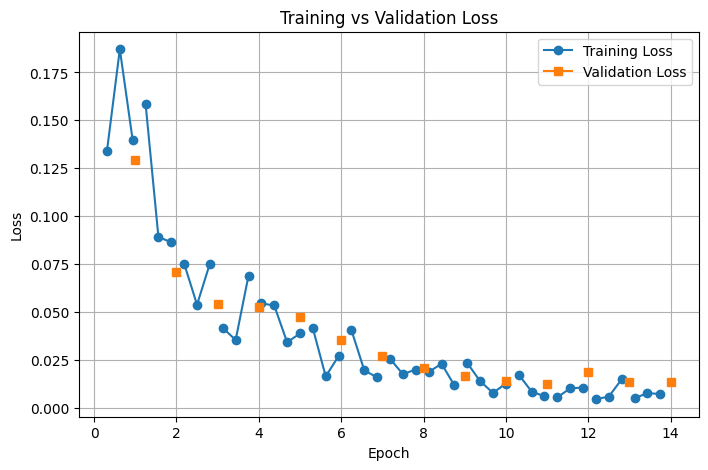

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract training logs
log_history = trainer.state.log_history

# Convert to DataFrame
df_logs = pd.DataFrame(log_history)[["epoch", "total_flos", "loss", "eval_loss"]]
df_logs = df_logs.dropna(how="all")

# Display available keys
print(df_logs.head())

plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["loss"], label="Training Loss", marker="o")
plt.plot(df_logs["epoch"], df_logs["eval_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [50]:
predictions = trainer.predict(valid_dataset)
preds = predictions.predictions.flatten()  # Flatten if single-output regression
labels = predictions.label_ids

# Convert to DataFrame
df_results = pd.DataFrame({"Actual": labels, "Predicted": preds})

# Display first few rows
print(df_results.head())

     Actual  Predicted
0  0.591346   0.561523
1  0.159915   0.128052
2  0.250188   0.337158
3  0.255751   0.241089
4  0.186418   0.116882


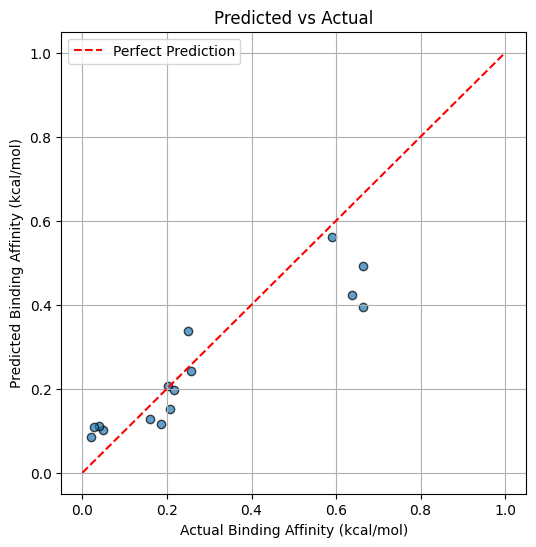

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(labels, preds, alpha=0.7, edgecolors="k")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Prediction")  # Identity line
plt.xlabel("Actual Binding Affinity (kcal/mol)")
plt.ylabel("Predicted Binding Affinity (kcal/mol)")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid()
plt.show()

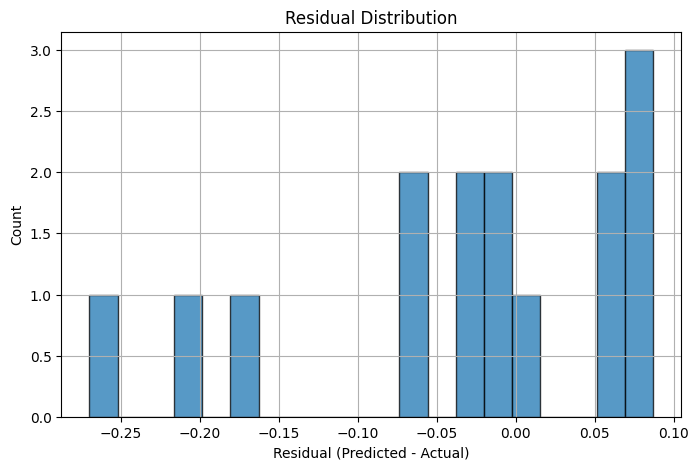

In [52]:
residuals = preds - labels

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, alpha=0.75, edgecolor="black")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid()
plt.show()

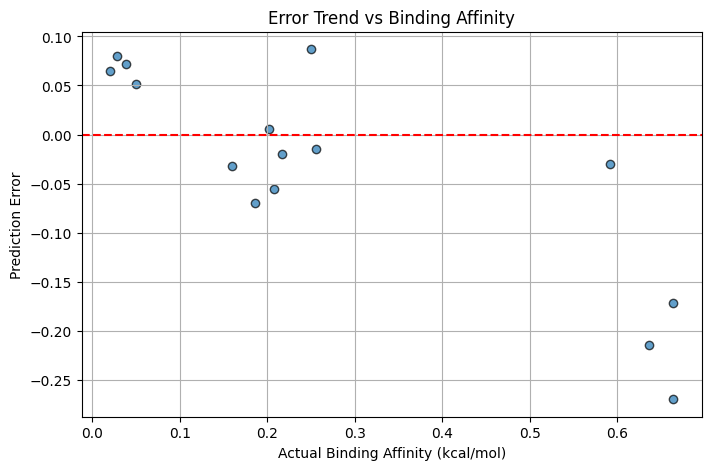

In [53]:
plt.figure(figsize=(8, 5))
plt.scatter(labels, residuals, alpha=0.7, edgecolors="k")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Actual Binding Affinity (kcal/mol)")
plt.ylabel("Prediction Error")
plt.title("Error Trend vs Binding Affinity")
plt.grid()
plt.show()